In [436]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [437]:
data = pd.read_csv('./data/data_indexes_moex_log_returns.csv', index_col=0)

In [438]:
from typing import List, Union


def MASE(y_true: pd.Series, y_pred: pd.Series) -> float:
    '''
    Вычисляет Mean Absolute Scaled Error (MASE) между фактическими и прогнозируемыми значениями.

    Параметры:
            y_true (pd.Series): Серия с фактическими значениями.
            y_pred (pd.Series): Серия с прогнозируемыми значениями.

    Возвращаемое значение:
            float: Значение MASE.
    '''
    # Создание наивного прогноза с использованием сдвига временного ряда
    naive_forecast = y_true.shift(1)
    naive_forecast.iloc[0] = y_true.iloc[0]

    # Вычисление средней абсолютной ошибки для модели и наивного прогноза
    average_errors = (y_true - y_pred).abs()
    naive_average_errors = (y_true - naive_forecast).abs()

    result = average_errors.mean() / naive_average_errors.mean()
    return result


def SMAPE(y_true: pd.Series, y_pred: pd.Series) -> float:
    '''
    Вычисляет Symmetric Mean Absolute Percentage Error (SMAPE) между фактическими и прогнозируемыми значениями.

    Параметры:
            y_true (pd.Series): Серия с фактическими значениями.
            y_pred (pd.Series): Серия с прогнозируемыми значениями.

    Возвращаемое значение:
            float: Значение SMAPE.
    '''
    # Избегание деления на ноль добавлением небольшого числа в знаменатель
    denominator = np.abs(y_true) + np.abs(y_pred) + np.finfo(float).eps
    result = (200 / len(y_true)) * np.sum(np.abs(y_pred - y_true) / denominator)
    return result


class TimeSeriesProcessor:
    '''
    Класс для работы с временными рядами, включая добавление лагов, интеграцию внешних переменных,
    создание разбиений для валидации, вычисление метрик и визуализацию результатов.

    Методы:
        add_lags(self, lags: List[int], drop_na: bool = True):
            Добавление лагов к переменным временного ряда.
        add_other_variables(self, other_variables: pd.DataFrame):
            Добавление дополнительных переменных к данным.
        get_folds(self, horizon: int = 25):
            Создание разбиений данных для тестирования.
        get_model_result(self, y_pred_list: List[pd.Series]):
            Вычисление и вывод метрик для модели.
        get_visualisation(self):
            Визуализация фактических и прогнозируемых значений.
    '''
    def __init__(
            self, 
            data: Union[pd.Series, pd.DataFrame], 
            target_name: str = None,
            interpolate: bool = True,
            dropna: bool = True
            ) -> None:
        '''
        Инициализирует объект класса с данными временного ряда.

        Параметры:
            data (Union[pd.Series, pd.DataFrame]): Временной ряд в формате pd.Series или pd.DataFrame.
            target_name (str, опционально): Имя целевой переменной в случае pd.DataFrame.
            interpolate (bool): Необходимо ли интерполировать данные.
            dropna (bool): Необходимо ли удалить пропущенные значения.
        '''
        if not isinstance(data.index, pd.DatetimeIndex):
            print('Новый тип индексов: pd.DatetimeIndex')
            data.index = pd.to_datetime(data.index)
        
        if interpolate:
            data = data.interpolate(method='time')
        
        if dropna:
            data = data.dropna()

        if isinstance(data, pd.Series):
            if target_name is not None:
                print("Предупреждение: target_name не нужно указывать для data: pd.Series")
            self.y = data
            self.X = pd.DataFrame(index=self.y.index)
        else:
            if target_name is None:
                raise ValueError("target_name обязательный параметр для data: pd.DataFrame")
            self.y = data[target_name]
            self.X = data.drop([target_name], axis=1)

        self.get_folds_was_called = False
        self.y_pred = None

    def add_lags(self, lags: List[int], drop_na: bool = True) -> None:
        '''
        Добавляет лаги (отставания) к временному ряду как новые признаки.

        Параметры:
            lags (List[int]): Список целых чисел, каждое из которых указывает на количество шагов отставания.
            drop_na (bool): Если True, то строки с пропущенными значениями после добавления лагов будут удалены.
        '''
        for lag in lags:
            self.X[f'lag_{lag}'] = self.y.shift(lag)

        if drop_na:
            self.X.dropna(inplace=True)
            self.y = self.y.loc[self.X.index]

        if self.get_folds_was_called:
            self.get_folds(horizon=self.horizon)

    def add_other_variables(self, other_variables: pd.DataFrame) -> None:
        '''
        Добавляет дополнительные внешние переменные к данным временного ряда.

        Параметры:
            other_variables (pd.DataFrame): DataFrame, содержащий внешние переменные для добавления.
        '''
        if other_variables.isna().any().any():
            print('Предупреждение: в other_variables есть пропуски. Алгоритм не предусматривает их наличие')

        self.X = pd.concat([self.X, other_variables], axis=1, join='inner')

        if self.get_folds_was_called:
            self.get_folds(horizon=self.horizon)

    def get_folds(self, horizon: int = 25, num_recent_folds: int = None) -> None:
        '''
        Создает разбиения данных для кросс-валидации на основе указанного горизонта прогнозирования.

        Параметры:
            horizon (int): Горизонт прогнозирования, используемый для создания тестовых разбиений.
            num_recent_folds (int, optional): Количество последних разбиений для включения в результат.
                Если не указано, используются все разбиения.
        '''
        self.horizon = horizon
        self.folds = []
        for i in range(0, len(self.X) - horizon, horizon):
            X_test = self.X.iloc[i:i + horizon]
            y_test = self.y.iloc[i:i + horizon]

            X_train = self.X.drop(X_test.index)
            y_train = self.y.drop(y_test.index)
            
            self.folds.append((X_train, y_train, X_test, y_test))
        
        if num_recent_folds is not None:
            self.folds = self.folds[-num_recent_folds:]
        
        self.get_folds_was_called = True

    def get_model_result(self, y_pred_list: List[pd.Series]) -> None:
        '''
        Вычисляет и выводит метрики качества модели на основе совокупности предсказаний.

        Параметры:
            y_pred_list (List[pd.Series]): Список pd.Series с прогнозами модели для каждого разбиения.
        '''
        self.y_pred = pd.concat(y_pred_list)
        self.y_true = self.y.loc[self.y_pred.index]

        self.mase = MASE(self.y_true, self.y_pred)
        self.smape = SMAPE(self.y_true, self.y_pred)

        print(f'MASE: {self.mase:.2f} (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)')
        print(f'SMAPE: {self.smape:.2f}% (на сколько % в среднем модель ошибается)')

    def get_visualisation(self, start_date=None, end_date=None) -> None:
        '''
        Отображает визуализацию сравнения фактических значений временного ряда с прогнозными.
        
        Параметры:
            start_date (str, optional): Начальная дата среза для визуализации в формате 'YYYY-MM-DD'.
                                        Если None, визуализация начинается с первой доступной даты.
            end_date (str, optional): Конечная дата среза для визуализации в формате 'YYYY-MM-DD'.
                                      Если None, визуализация идет до последней доступной даты.
        '''
        if self.y_pred is None:
            raise ValueError('Метод get_visualisation должен вызываться после вызова метода get_model_result')
        
        # Создание копий серий для обеспечения возможности среза
        y_true_sliced = self.y_true.copy()
        y_pred_sliced = self.y_pred.copy()
        
        # Применение среза, если указаны даты
        if start_date:
            y_true_sliced = y_true_sliced[start_date:]
            y_pred_sliced = y_pred_sliced[start_date:]
        if end_date:
            y_true_sliced = y_true_sliced[:end_date]
            y_pred_sliced = y_pred_sliced[:end_date]
        
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=y_true_sliced, label="Actual")
        sns.lineplot(data=y_pred_sliced, label="Predicted")
        plt.title("Actual vs Predicted")
        plt.legend()
        plt.show()

# Пример использования

Запихиваем ряд с доходностями в экземпляр класса

In [439]:
ts = TimeSeriesProcessor(data=data.MOEXMM)


Новый тип индексов: pd.DatetimeIndex


Добавляем лаговые переменные (какие хотим). Они автоматически появятся в ts.X

In [440]:
ts.add_lags(lags=[1, 2, 3, 4, 5, 10, 30])

Дробим на фолды (как говорил Александр Владимирович). num_recent_folds нужен для ускорения работы. Если алгоритм будет работать очень долго, можно будет просто взять только несколько последних фолдов и получить среднее предсказание по ним

In [441]:
ts.get_folds(horizon=30, num_recent_folds=None) 

так мы можем добавть любые переменные в модель в виде pd.Dataframe. Они автоматически появятся в ts.X

In [442]:
# ts.add_other_variables(other_variables=any_data)

Обучаем модель на каждом трейне и предсказываем тест на каждом фолде. Для этого циклом проходимся по ts.folds. Он является списком кортежей, уже включающих в себя X_train, y_train, X_test, y_test. Каждый элемент списка - фолд

In [443]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

y_pred_list = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):  # tqdm чтобы визуализировать загрузку

    model.fit(X_train, y_train)

    y_pred = pd.Series(
        model.predict(X_test),
        index=X_test.index
    ) # Класс принимает только pandas форматы, а model.predict возвращает np.array. Поэтому преобразую в pd.Series

    y_pred_list.append(y_pred) 

100%|██████████| 158/158 [00:01<00:00, 116.45it/s]


Выводим совокупный результат на всех тестах всех фолдов

In [444]:
ts.get_model_result(y_pred_list) 

MASE: 0.72 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)
SMAPE: 173.01% (на сколько % в среднем модель ошибается)


Можем визуализировать работу модели

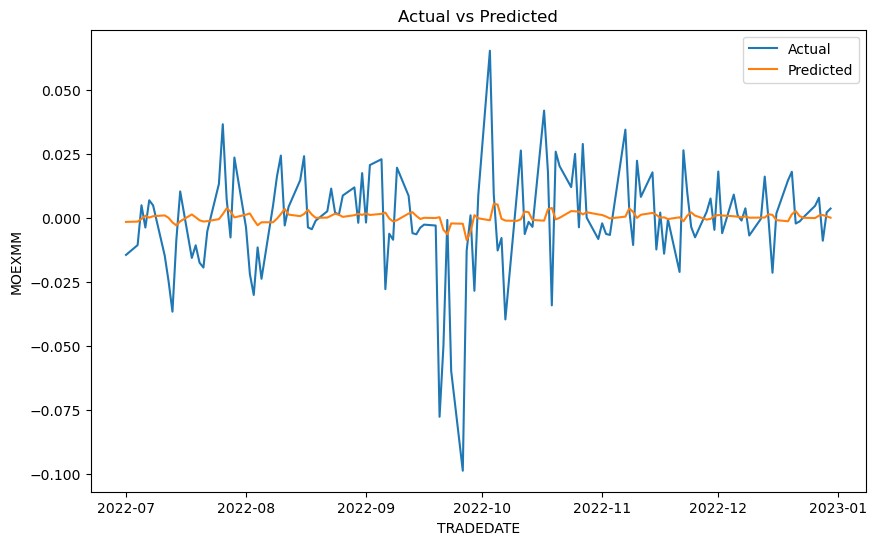

In [445]:
ts.get_visualisation(start_date='2022-07-01', end_date='2023-01-01')

Также в ходе работы можно посмотреть на состояние предикторов в любой момент времени

In [446]:
ts.X.head()

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_10,lag_30
TRADEDATE,,,,,,,
2005-02-24,0.005027,0.011620,-0.001743,0.007954,0.005600,-0.011543,-0.013441
2005-02-25,0.039721,0.005027,0.011620,-0.001743,0.007954,0.005217,-0.005678
2005-02-28,0.004220,0.039721,0.005027,0.011620,-0.001743,-0.001106,0.027919
2005-03-01,0.044779,0.004220,0.039721,0.005027,0.011620,-0.009049,-0.000594
2005-03-02,-0.027531,0.044779,0.004220,0.039721,0.005027,0.017094,-0.017105


Те лаги и признаки, которые мы добавляем, автоматически попадают в ts.X

На таргет тоже могу посмотреть

In [447]:
ts.y.head() # На таргет тоже могу посмотреть

TRADEDATE
2005-02-24    0.039721
2005-02-25    0.004220
2005-02-28    0.044779
2005-03-01   -0.027531
2005-03-02   -0.014182
Name: MOEXMM, dtype: float64